## a-AlphaBio homework problem
### Mark Thompson
### Started April 29, 2024 

#### scFv single-chain fragments of Pembrolizumab; which targets the programmed cell death protein 1 (PD-1) receptor of lymphocytes.
https://en.wikipedia.org/wiki/Pembrolizumab


---------------
## TODO:
* <span style="color:red">Examine possible use of sequence_alpha?? (there is only 1 unique sequence here though).</span>

* <span style="color:red">Is there overlap between the Nature scFv data set and the homework dataset?  If not, use the former for pre-training??</span>
* <span style="color:red">Make sure Kd, Kd_lower_bound ,Kd_upper_bound properly ordered</span>
* <span style="color:red">Examine: q_value: The false discovery rate of the Kd measurement, relative to negative controls</span>
* <span style="color:red">Try linear Attention module with mixed-precision to crank-up the layers, heads, etc</span>
* <span style="color:red">Don't forget to save checkpoints based on val_loss (not loss)</span>
* <span style="color:red">Make sure scFv_dataset is putting out the correct sequences (wrt special tokens), i.e. no PAD needed </span>
* <span style="color:red">See if predicted affinities also follow a bimodal pattern </span>


-----------
## Dataset 1 summary (from below analysis)
* 29199 unique aa sequences for scFv (split 90/10 train/val)
* all Kd values > 0 (no NANs)
* all sequences are same length: 246 residues

-----------

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline

----
### Data set analysis
* remove rows with NAN for Kd (note: NAN may indicate a non-binding or very very poor binding event. I could impute a very high value for Kd for these cases.  I will ignore them in this first pass)

* also check for any Kd values < 0 (there were some in the dataset from the Nature paper)
* identify duplicate sequences and accumulate Kd values for these.
* for duplicates, take the Kd value as the mean of the Kd values over the duplicate sequences.  Caveat: eyeball these first to ensure the Kd values are NOT widely spread in value.

In [3]:
data_file = '../data/alphaseq_data_train.csv'
df = pd.read_csv(data_file)
rows1 = df.shape[0]
print('starting dataframe has', rows1, 'rows')
print(df.columns.tolist())

starting dataframe has 30049 rows
['description_a', 'sequence_a', 'description_alpha', 'sequence_alpha', 'Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value']


In [4]:
# Remove Kd nans
#
df = df.dropna(subset=['Kd'])
rows2 = df.shape[0]
print('after removing nans, dataframe has', rows2, 'rows; (there were', rows1-rows2, 'rows with Kd=nan)')

after removing nans, dataframe has 29358 rows; (there were 691 rows with Kd=nan)


In [5]:
# Do I need to remove Kd vals that are negative?
#
num_negatives = (df[df['Kd'] > 0]).shape[0] - rows2
print('There are', num_negatives, 'Kd values < 0')

There are 0 Kd values < 0


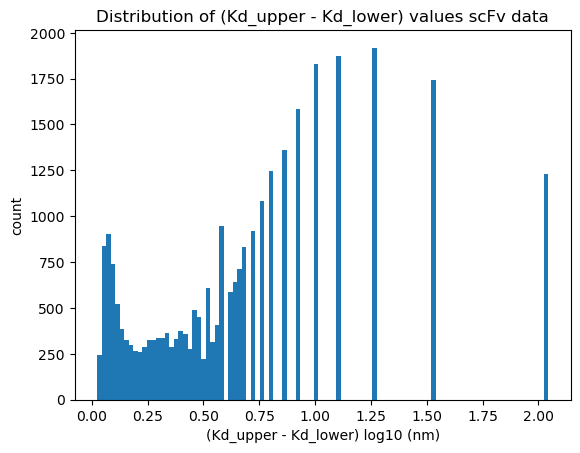

In [6]:
# Get the Kd,Kd_lower_bound,Kd_upper_bound columns
#
deltas = df['Kd_upper_bound'] - df['Kd_lower_bound']
qvals = df['q_value']
plt.hist(deltas, bins=100)
plt.xlabel('(Kd_upper - Kd_lower) log10 (nm)')
plt.ylabel('count')
plt.title('Distribution of (Kd_upper - Kd_lower) values scFv data')
plt.show()

df shape: (29358, 8)


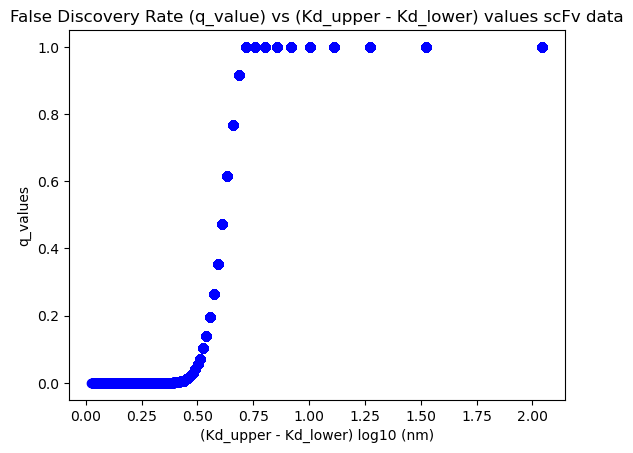

In [7]:
# Scatter plot of q_value vs (Kd_upper - Kd_lower)
#
print('df shape:', df.shape)
plt.scatter(deltas, qvals, c ="blue")
plt.xlabel('(Kd_upper - Kd_lower) log10 (nm)')
plt.ylabel('q_values')
plt.title('False Discovery Rate (q_value) vs (Kd_upper - Kd_lower) values scFv data')
# plt.xlim(0, 5)
# plt.ylim(0, 5)
plt.show()


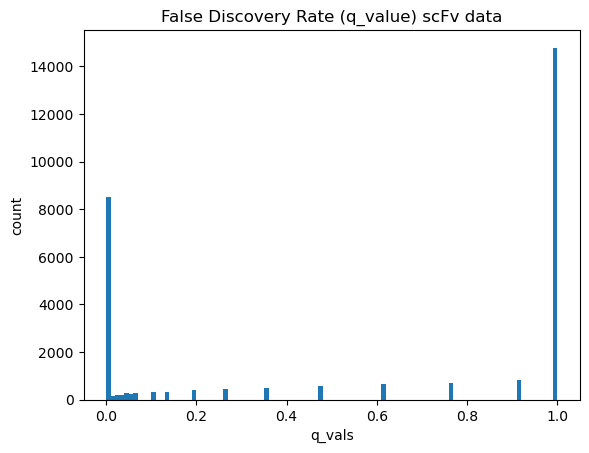

In [8]:
qvals = df['q_value']
plt.hist(qvals, bins=100)
plt.xlabel('q_vals')
plt.ylabel('count')
plt.title('False Discovery Rate (q_value) scFv data')
plt.show()

In [18]:
# Remove rows with q_values > 0.5  
#
df = df[df['q_value'] <= 0.05]
print(df.shape)

(9302, 8)


In [19]:
# Identify duplicate sequences and process their multiple Kd values
#
seqs = {} # will contain a list for binding energies for each unique sequence
for index, row in df.iterrows():
    seq = row['sequence_a']
    affinity = row['Kd']
    if seq not in seqs:
        seqs[seq] = list()
        seqs[seq].append(affinity)
    else:
        seqs[seq].append(affinity)

print('Number of unique sequences:', len(seqs))
print('First few entries')
for i, (k, v) in enumerate(seqs.items()):
    assert len(v) > 0, 'empty set for sequence'
    print(i, ':', 'num values:', len(v), ', values:', v)
    if i > 2:
        break

Number of unique sequences: 9250
First few entries
0 : num values: 51 , values: [1.2419628532129607, 1.3793547618634392, 1.1528594007742932, 1.1234871650658107, 1.161712868152616, 1.2252489460847826, 1.14559440926973, 1.128879976800924, 1.7984106042189367, 1.230264572870599, 1.1621030996620227, 2.088821673811601, 1.3130583571705543, 1.2244431358569834, 1.07105556422146, 1.2743967956448543, 1.8403837615756624, 1.1809028058854487, 1.2259335606406836, 1.3874729233398604, 1.0762728869166516, 1.4316441320626296, 1.2952890150171044, 1.3216025753034089, 1.2125037883629624, 1.1203545820858132, 1.3599596604472983, 1.1974700981104824, 1.3800538510679736, 1.2916007065814554, 1.2630263933743286, 1.2375541773776035, 1.1098785336541042, 1.7517630817399734, 1.0187118584110166, 1.1040702794938184, 1.3817934595452217, 1.3580189710309725, 1.123542623094604, 1.0643779140832734, 1.61937429500583, 2.1767792021213417, 1.141271146637056, 1.8645551415983483, 1.3440541152050225, 1.296708623038473, 1.4102950339

In [20]:
# Calc the mean Kd for all unique sequences:
# calc the mean of the binding affinities for each sequence
seqs_mean_Kd = {}
for k,v in seqs.items():
    seqs_mean_Kd[k] = np.mean(v)

# Is there a distribution of lengths for scFv ?
s = set([len(k) for k,v in seqs_mean_Kd.items()])
print('Total number of different sequence lengths:', len(s), ', and it is', s, 'aa residues long')

Total number of different sequence lengths: 1 , and it is {246} aa residues long


In [21]:
# calc binding free energy (in kcal/mol) from Kd 
# affinity is Kd in nM
R = 1.98722 # cal/(mol*K)
T = 298.15 # K
def delta_G(Kd):
    delG = R * T * math.log10(Kd * 1e-9)    # or -RT log10(Ka)
    return delG/1000


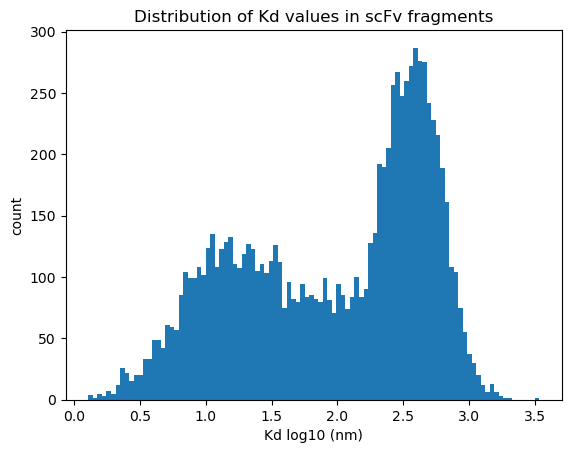

In [22]:
# Histogram of Kd values
#
kds = [v for k,v in seqs_mean_Kd.items()]
plt.hist(kds, bins=100)
plt.xlabel('Kd log10 (nm)')
plt.ylabel('count')
plt.title('Distribution of Kd values in scFv fragments')
plt.show()

# Interesting that it appears somewhat bi-modal

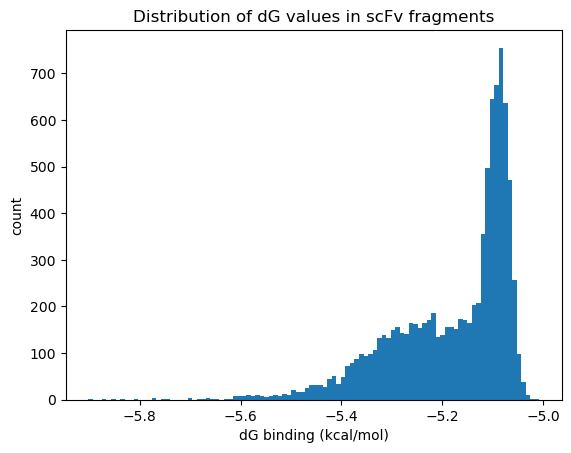

In [23]:
# Histogram of dG binding values
#
kds = [delta_G(v) for k,v in seqs_mean_Kd.items()]
plt.hist(kds, bins=100)
plt.xlabel('dG binding (kcal/mol)')
plt.ylabel('count')
plt.title('Distribution of dG values in scFv fragments')
plt.show()


mutations start at position 29 and end at position 108
length of mutation region: 80


(0.0, 20.0)

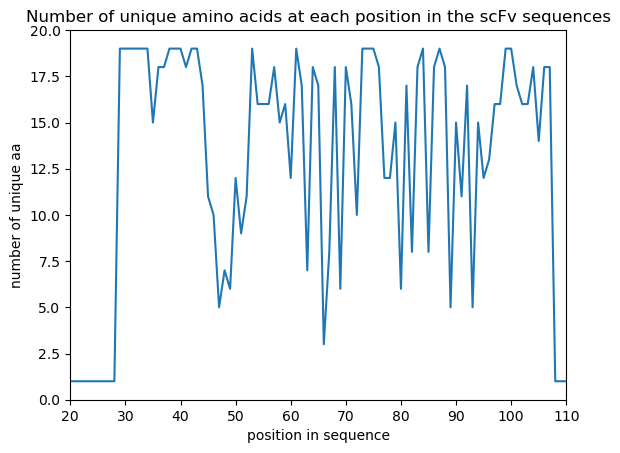

In [24]:
# Get a sense of the frequency of mutation in each aa position in the scFv sequences
#
aa_sets = [set() for i in range(246)]

for k,v in seqs_mean_Kd.items():
    for i in range(len(k)):
        aa_sets[i].add(k[i])

counts = [len(x) for x in aa_sets]

# find first index where counts is > 1
firstIdx = next(x for x, val in enumerate(counts) if val != 1)
# and when it drops to 1 again
lastIdx = firstIdx + next(x for x, val in enumerate(counts[firstIdx:]) if val == 1)

# Mutations occur in a CDR region
print('mutations start at position', firstIdx, 'and end at position', lastIdx)
print('length of mutation region:', lastIdx-firstIdx+1)

# plot the number of unique aa at each position in the sequence
plt.plot(counts)
plt.xlabel('position in sequence')
plt.ylabel('number of unique aa')
plt.title('Number of unique amino acids at each position in the scFv sequences')
plt.xlim(20, 110)
plt.ylim(0, 20)

### Create train/val split  (90/10)

In [25]:
# Create the train and test sets and save as csv files
seqs = [k for k,v in seqs_mean_Kd.items()]
kds  = [v for k,v in seqs_mean_Kd.items()]

df_out = pd.DataFrame({'sequence_a': seqs, 'Kd': kds})

# Train/val split 90/10
df_train = df_out.sample(frac=0.9, random_state=42)
df_val = df_out.drop(df_train.index)
print('train:', df_train.shape, ', val:', df_val.shape)

# DON'T re-save the data, as it is already saved!!
# save to csv
# df_train.to_csv('../data/q_cleaned_3_train_set.csv', index=False)
# df_val.to_csv('../data/q_cleaned_3_val_set.csv', index=False)


train: (8325, 2) , val: (925, 2)


### Ensure that train and val sets show same qualitative bimodal shape like above

In [ ]:
# Histogram of Kd values
#
kds_train = df_train['Kd'].to_list()
kds_val = df_val['Kd'].to_list()

fig, axs = plt.subplots(1, 2)
fig.suptitle('Distribution of Kd values in scFv fragments')
axs[0].hist(kds_train, bins=50)
axs[0].set_title('Train Data')

axs[1].hist(kds_val, bins=50)
axs[1].set_title('Validation Data')

for ax in axs.flat:
    ax.set(xlabel='Kd log10 (nm)')




----
### The holdout dataset

In [ ]:
# The holdout data
data_file = '../data/alphaseq_data_hold_out.csv'
df = pd.read_csv(data_file)
rows1 = df.shape[0]
print('holdout dataframe has', rows1, 'rows')
print(df.columns.tolist())
print(df['sequence_a'].describe())

In [ ]:
# Calc how many unique string lengths of sequence_a column there are
s = set([len(k) for k in df['sequence_a']])
print('Total number of different sequence lengths:', len(s), ', and they are', s, 'aa residues long')
# get the count of each length
df['sequence_a'].apply(len).value_counts()